In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from matplotlib.pyplot import scatter
from operator import itemgetter
from sklearn.decomposition import PCA

import utils

In [19]:
train1_df = pd.read_csv('BATADAL_dataset03.csv', index_col=0)
train2_df = pd.read_csv('BATADAL_dataset04.csv', index_col=0)

In [21]:
train2_df = train2_df.rename(columns=lambda x: x.strip())
train2_df.index = pd.to_datetime(train2_df.index, dayfirst=True)

X_train1 = train1_df.drop(['ATT_FLAG'], axis=1).values
y_train1 = train1_df['ATT_FLAG'].values
X_train2 = train2_df.drop(['ATT_FLAG'], axis=1).values
y_train2 = train2_df['ATT_FLAG'].values
print(np.shape(X_train1))
print(np.shape(X_train2))


(8761, 43)
(4177, 43)


In [22]:
#Standarizing the data
scaler = StandardScaler()
X_std = scaler.fit_transform(X_train1)
X_std2 = scaler.transform(X_train2)

print(np.shape(X_std))

# eigendecomposition on the covariance matrix:
cov_mat = np.cov(X_std.T)
cov_mat2 = np.cov(X_std2.T)
print(np.shape(cov_mat))

eig_vals, eig_vecs = np.linalg.eig(cov_mat)
print(np.shape(eig_vecs))

eig_vals2, eig_vecs2 = np.linalg.eig(cov_mat2)

(8761, 43)
(43, 43)
(43, 43)


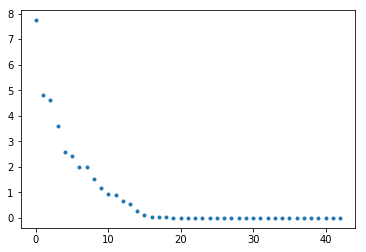

In [23]:
eig_vals_sort = np.sort(eig_vals)[::-1]

plt.plot(eig_vals_sort, '.')
plt.show()

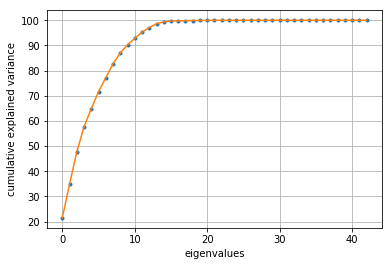

In [24]:
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

plt.plot(cum_var_exp, '.')
plt.plot(cum_var_exp, '-')
plt.xlabel('eigenvalues')
plt.ylabel('cumulative explained variance')
plt.grid()
plt.show()

In [25]:
pca = PCA(n_components=15)
pca.fit(X_std)
scores = pca.transform(X_std)
reconstruct = pca.inverse_transform(scores )
residual_pca1=X_std-reconstruct
residual_pca1 = np.sqrt(np.square(residual_pca1))
print(np.shape(residual_pca1))
residual_full = np.sum(residual_pca1, axis=1)
print(np.shape(residual_full))


(8761, 43)
(8761,)


(8761,)
(4177, 43)
(8761,)


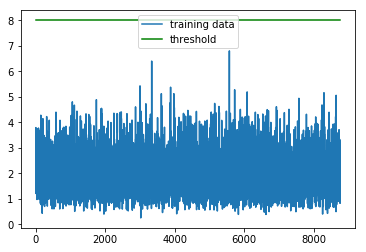

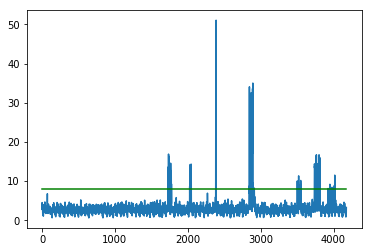

In [26]:
residual_full = np.sum(residual_pca1, axis=1)
print(np.shape(residual_full))
scores2 = pca.transform(X_std2)
# Reconstruct from the 2 dimensional scores 
reconstruct2 = pca.inverse_transform(scores2)

residual_pca2=X_std2-reconstruct2
residual_pca2 = np.sqrt(np.square(residual_pca2))
print(np.shape(residual_pca2))
residual_full2 = np.sum(residual_pca2, axis=1)
print(np.shape(residual_full))

threshold = 8

plt.plot(residual_full, label='training data')
plt.plot([0,len(residual_full)],[threshold, threshold],'g', label='threshold')
# plt.title('Full residual')
plt.legend()
plt.show()

plt.plot(residual_full2, label='val')
plt.plot([0,len(residual_full2)],[threshold, threshold],'g')
# plt.title('Full residual')
plt.show()

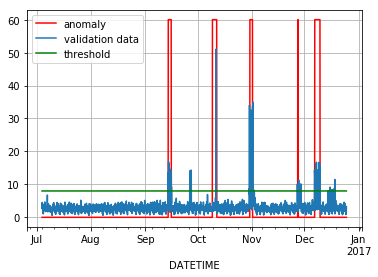

In [27]:
train2_df['threshold'] = np.ones(len(train2_df))*threshold
train2_df['ATT_FLAG_anom'] = np.where(train2_df['ATT_FLAG'] == 1, 60, 0)
ax = train2_df['ATT_FLAG_anom'].plot(grid=True, color='r', label='anomaly')
train2_df['pca_anom'] = residual_full2
ax2 = train2_df['pca_anom'].plot(grid=True, label='validation data')
ax3 = train2_df['threshold'].plot(grid=True, color='g', label='threshold')
plt.legend(loc=2)
plt.show()

In [28]:
#indices where positive occurs
ind = np.argwhere(residual_full2 > threshold).reshape(-1)
y_pred = np.where(residual_full2 > threshold, 1, 0)
P_am = np.where(y_train2 == 1) # indices with positive
N_am = np.where(y_train2 == -999) # indices with negative

# print(N_am)
# print(len(ind))

mask_TP = np.isin(ind, P_am)
mask_NP = np.isin(ind, N_am)

TP = len(ind[mask_TP])
FP = len(ind[mask_NP])
TN = np.shape(N_am)[1] - FP
FN = np.shape(P_am)[1] - TP

# print(TP, FP, TN, FN)
# print(TP + FP + TN + FN, np.shape(P_am)[1] + np.shape(N_am)[1], len(residual_full2))

accuracy = (TP+TN)/len(y_train2)
precision = TP/(TP+FP)
recall = TP/(np.shape(P_am)[1])
S_TTD = utils.TDD_metric(train2_df, y_pred)
S_CM = utils.S_cm(TP, FP, TN, FN)
print('accuracy: {}, precision: {}, recall: {}'.format(accuracy, precision, recall))
print('TDD: {}'.format(S_TTD))
print('S_cm: {}'.format(S_CM))
print('Ranked: {}'.format(0.5 * S_TTD + 0.5 * S_CM))

accuracy: 0.9535551831457985, precision: 0.5838926174496645, recall: 0.3972602739726027
TDD: 0.7838662047566156
S_cm: 0.6907978984820062
Ranked: 0.7373320516193109
